## Overview Process

# 1. Feature Engineering

In [3]:
import pandas as pd

In [4]:
import json
with open('types.json', 'r') as f:
    data_types = json.load(f)

In [5]:
df = pd.read_feather('featherdata.feather')

In [6]:
df = df.astype(data_types)

## 2. Clean Missing Values

In [8]:
from missing_values import some_nans, nas_sorted

def impute_means(df):
    nan_cols = some_nans(df)
    col_means = df[nan_cols].mean()
    imputed_df = df.fillna(col_means)
    return imputed_df

# find columns with nas, impute means

In [9]:
imputed_df = impute_means(df)

In [10]:
cleaned_df = imputed_df.drop(columns = ['host_acceptance_rate', 'jurisdiction_names'])

In [11]:
y = cleaned_df.price

In [12]:
X = cleaned_df.drop(columns=['price'])

In [13]:
some_nans(imputed_df)

Index([], dtype='object')

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [15]:
cleaned_df.isnull().values.any()

False

## Using RFE

## 1. Split Data and Plot Features

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
# Perhaps do this faster with the grid scores

from sklearn.feature_selection import RFECV
model = LinearRegression(n_jobs = -1)
rfecv = RFECV(model, cv = 5)
X_train_rfecv = rfecv.fit(X_train,y_train)


In [18]:
grid_scores = X_train_rfecv.grid_scores_
x_value_range = list(range(0, 303))[::-1]

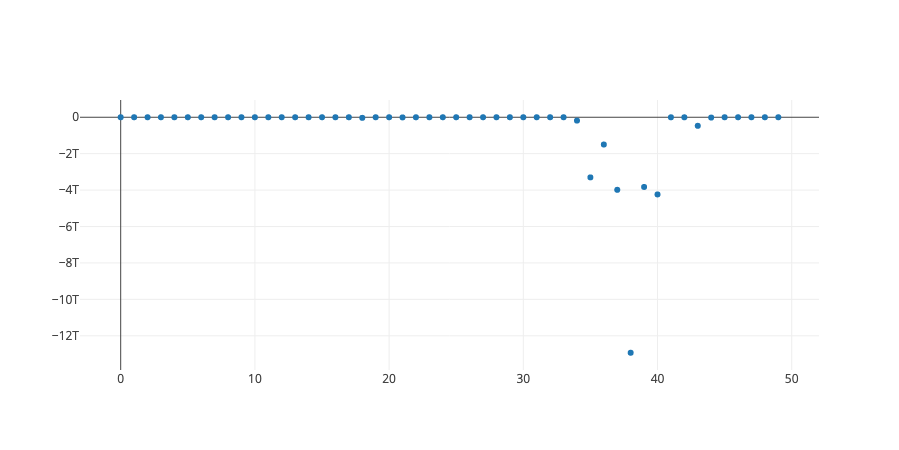

In [19]:
from graph import trace_values, plot
score_trace = trace_values(x_value_range[-50:], grid_scores[-50:])
plot([score_trace])

In [20]:
from sklearn.feature_selection import RFE
selectors = []
for idx in list(range(2, 300, 10))[::-1]:
    estimator = LinearRegression(n_jobs=-1)
    rfe = RFE(estimator, idx, step=1)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    
    estimator.fit(X_train_rfe,y_train)
    score = estimator.score(X_test_rfe,y_test)
    selectors.append((estimator, score, idx))

* Plot scores per number of features

In [21]:
import numpy as np
wrapped_selectors = np.array(selectors)
wrapped_selectors[:3]

array([[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
        -903.9626373975552, 292],
       [LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
        -117014.18090214423, 282],
       [LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
        -73000.37591720892, 272]], dtype=object)

In [22]:
n_features = wrapped_selectors[:, -1]
n_features[:5]

array([292, 282, 272, 262, 252], dtype=object)

In [23]:
scores = wrapped_selectors[:, 1]
scores[:5]

array([-903.9626373975552, -117014.18090214423, -73000.37591720892,
       0.10114809409191683, -270.3432953287555], dtype=object)

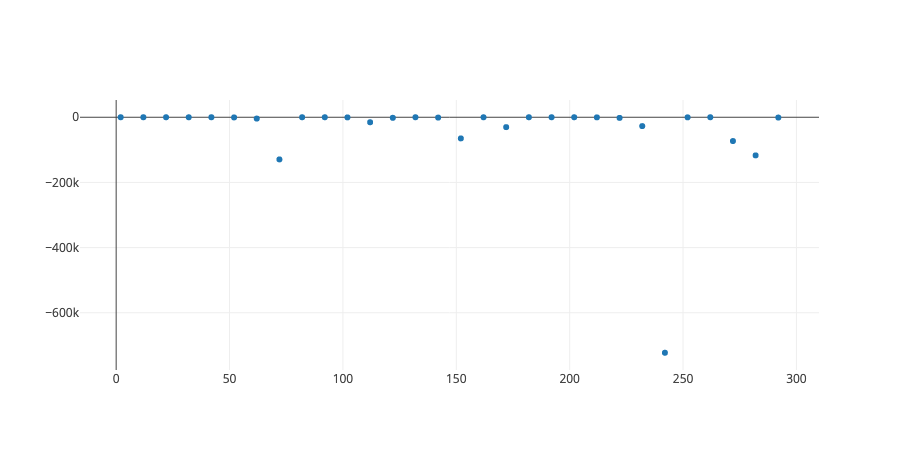

In [24]:
from graph import trace_values, plot
scores_trace = trace_values(n_features, scores)
plot([scores_trace])

We can see that our scores never get above 10 percent.  And when we drop below 60 features, quickly perform worse than our mean.

### Weak Scores, Explore Outliers

* Our scores are pretty weak.  It could just be a few datapoints that are throwing off our scores.  Let's do a a deeper dive into our target variable.

1. Plot histogram of target variable

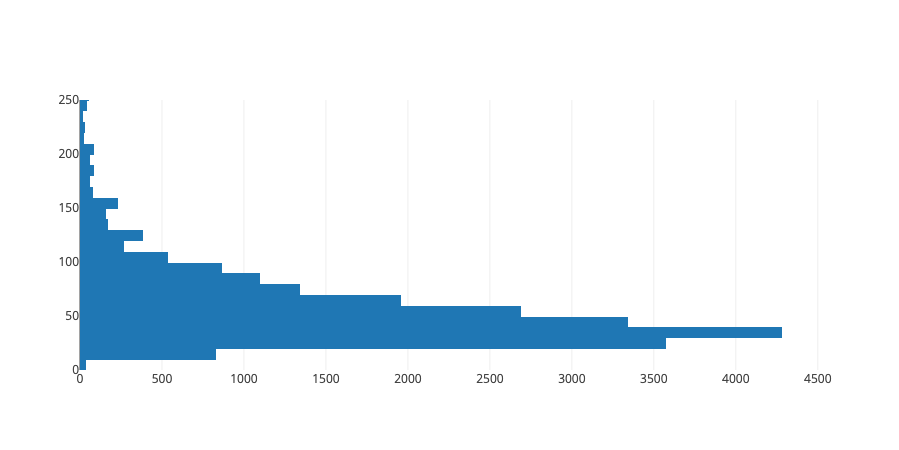

In [25]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np 

data = [go.Histogram(y=y)]
plot(data, layout = {'yaxis': {'range': [0, 250]}})

We can see that our data is skewed to the right, and has outliers.  Let's attach some numbers to this distribution.

### Examining Outliers

### A. Examine the Low End

* Here, removing the outliers could be justified, especially the ones close to and equal to zero.  Who is charging so little for a room to rent?

In [26]:
len(y)
# 22552

len(y[y < 30])
# 4444

len(y[y < 20])
# 867

len(y[y < 10])
# 35

len(y[y == 0])
# 8

8

We see that a large number of listings charge under 30 dollars, so all of these can't be wrong.  However, the 35 that are less than ten dollars and the 8 that are either incorrect, or extreme enough for us to remove.  

### B. Examine the High End

In [27]:
y.sort_values(ascending=False).head(10)

6655     9000.0
21389    8600.0
15665    8000.0
19372    6000.0
19415    6000.0
19657    6000.0
19658    6000.0
19659    6000.0
19660    6000.0
19661    6000.0
Name: price, dtype: float64

In [28]:
(y > 1000).sum()

37

### C. See the broader distribution

In [29]:
step = 100
bin_range = np.arange(0, 500+step, step)
out, bins  = pd.cut(y, bins=bin_range, include_lowest=True, right=False, retbins=True)
out.value_counts(sort=False)

[0, 100)      20016
[100, 200)     2040
[200, 300)      306
[300, 400)       73
[400, 500)       31
Name: price, dtype: int64

So we can see that almost all of the data is between 0 and 200.  We are skeptical of the data that precisely equals 0.  And perhaps may not be able to properly predict the outliers in a linear model.

##  3. Correct the Outliers 

We now have three approaches for us to try:

1. Remove outliers in general
1. Remove low end data that seems incorrect
3. Take a logarithm of the distribution 

### Solution One: Clip the outliers

In [30]:
lower, upper = np.percentile(y, [1,99]) # find middle 98% of prices
clipped = np.clip(y, upper, lower)

In [31]:
lower, upper

(15.0, 270.0)

In [32]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.set_xlabel('Prices in middle 98% range')
ax.set_ylabel('Num Apts at that price')
ax.hist(clipped, bins=45)
plt.show()

<Figure size 640x480 with 1 Axes>

In [33]:
cleaned_df.shape

(22552, 304)

Now clip the entire dataframe and model.

In [34]:
clipped_df = cleaned_df[(lower < cleaned_df.price) & (cleaned_df.price < 270.0)]

In [35]:
y = clipped_df.price

In [36]:
X = clipped_df.drop(columns=['price'])

In [37]:
model = LinearRegression(n_jobs = -1)
rfecv = RFECV(model, cv = 5)

rfecv.fit(X,y)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [38]:
y_values = rfecv.grid_scores_
x_values = list(range(0, 303))

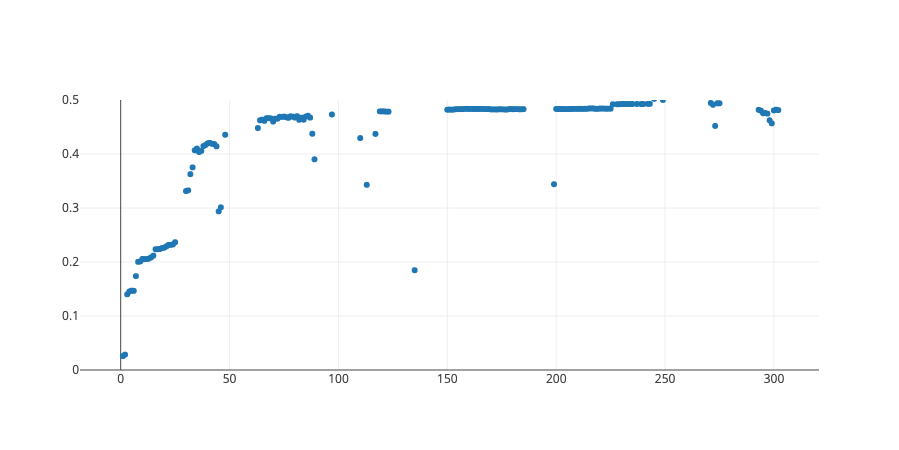

In [39]:
trace = trace_values(x_values, y_values)
plot([trace], {'yaxis': {'range': [0, .5]}})

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [41]:
from sklearn.feature_selection import RFE

In [42]:
rfe = RFE(model, n_features_to_select= 40)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
  n_features_to_select=40, step=1, verbose=0)

In [43]:
selected_columns = X_train.columns[rfe.support_]

In [44]:
model.fit(X_train[selected_columns], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [45]:
model.score(X_test[selected_columns], y_test)

0.3756859841009884

Not bad!

## Solution Two: Only remove the bottom scores

In [46]:
removed_lower_df = cleaned_df[(10 < cleaned_df.price)]

In [47]:
y_removed_lower = removed_lower_df.price
X_removed_lower = removed_lower_df.drop(columns=['price'])
model = LinearRegression(n_jobs = -1)
rfecv_removed_lower = RFECV(model, cv = 5)

rfecv_removed_lower.fit(X_removed_lower,y_removed_lower)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [48]:
y_values_removed_lower = rfecv_removed_lower.grid_scores_
x_values_removed_lower = list(range(0, 303))

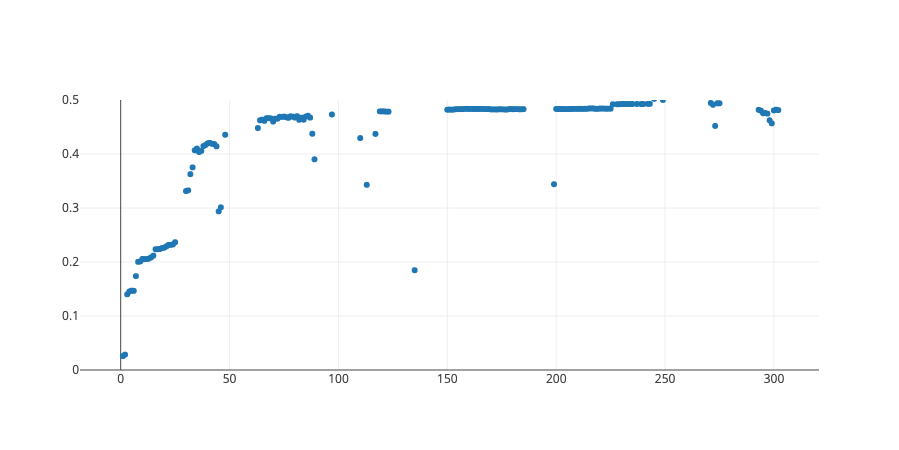

In [49]:
trace_dropped_lower = trace_values(x_values, y_values)
plot([trace_dropped_lower], {'yaxis': {'range': [0, .5]}})

This did not work so well.

## Solution Two: Take the log

Remember that our distribution of prices is a right tailed distribution.

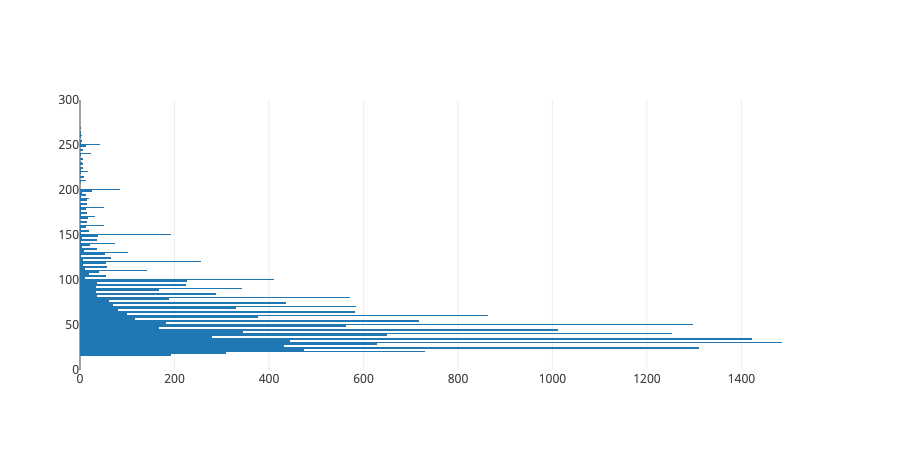

In [50]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np 

data = [go.Histogram(y=y)]
plot(data, layout = {'yaxis': {'range': [0, 300]}})

Taking the log is good for right tailed distributions because it has the tendancy to spread out less than one, and squish in large numbers.  

What's the log?

* The log is the inverse of taking the exponent.

* For example, a differnece of 900, leads to just a difference of 2 when we take the log.

In [51]:
np.log(100)
# 4.605

np.log(1000)
# 6.90775

6.907755278982137

In [52]:
np.log(.5)
# -0.693

np.log(.2)
# -1.609

-1.6094379124341003

* One thing to note is that we cannot take the log of a negative number.

In [53]:
np.log(-1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in log



nan

Nor zero.

In [54]:
np.log(0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log



-inf

So we need to remove the values that equal zero, and then take the log.

In [55]:
cleaned_df.shape

(22552, 304)

In [56]:
is_zeros = cleaned_df.price == 0
df_removed_zeros = cleaned_df[~is_zeros]

In [57]:
y_removed_logged = np.log(df_removed_zeros.price)
X_removed = df_removed_zeros.drop(columns=['price'])

In [58]:
model = LinearRegression(n_jobs = -1)
rfecv_log = RFECV(model, cv = 5)

rfecv_log.fit(X_removed,y_removed_logged)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [59]:
y_values_log_scores = rfecv_log.grid_scores_
x_values = list(range(0, 303))

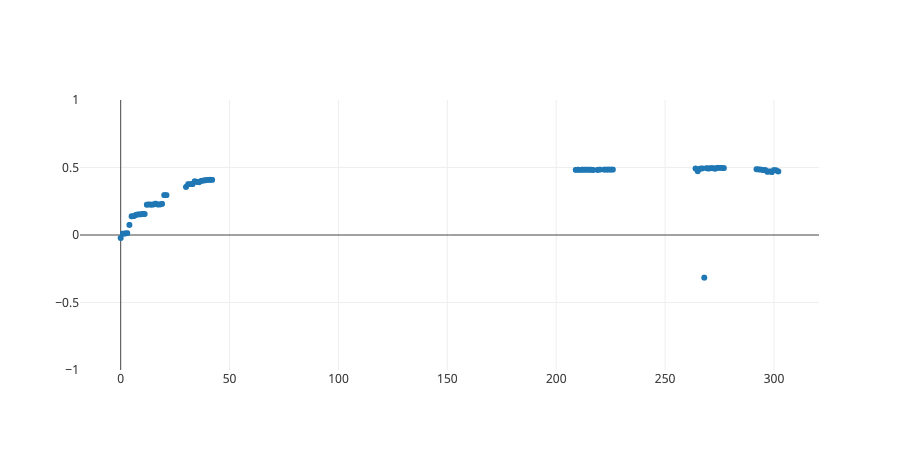

In [60]:
from graph import plot, trace_values

trace_logged_scores = trace_values(x_values, y_values_log_scores)
plot([trace_logged_scores], {'yaxis': {'range': [-1, 1]}})

We got to .40 with 35 features. 

This is about as well as we performed with our clipped dataset.  So we can stick with this.  We need to remember that we are proceeding forward with the following formula:

$$ log(y) = Ax $$

In [61]:
df_removed_zeros.reset_index()

df_removed_zeros.reset_index().to_feather('removed_zeros.feather')

## Interpret taking the log 

* Log linear relationship 

$log(y) = \theta_1x_1 + \theta_2x_2 + x_3$

Let's see how any feature influences our output, y.

$ y = e^{\theta_1x_1 + \theta_2x_2 + x_3} $

$\frac{\partial y}{\partial x_1} = \theta_1*e^{\theta_1x_1 + \theta_2x_2 + x_3} $

$\frac{\partial y}{\partial x_1} = \theta_1*y $

So now, if $\theta_1 = .1$, then a one unit change in x leads to a $.1y$ increase in $y$.  In other words, y increases by 10 percent.

> Notes from David Dranove, Northwestern University

## Rank the features

Now let's see which features we selected.

In [62]:
y_removed_logged = np.log(df_removed_zeros.price)
X_removed = df_removed_zeros.drop(columns=['price'])

In [119]:
from sklearn.feature_selection import RFE
model = LinearRegression()

rfe_logged_model = RFE(model, n_features_to_select=35)
rfe_logged_model.fit(X_removed, y_removed_logged)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=35, step=1, verbose=0)

In [146]:
len(X_removed.columns[rfe_logged_model.support_])
# 35

selected_cols = X_removed.columns[rfe_logged_model.support_]
pruned_X_removed = X_removed.iloc[:, rfe_logged_model.support_]

In [147]:
X_train_pruned, X_test_pruned, y_train_pruned, y_test_pruned = train_test_split(
     pruned_X_removed, y_removed_logged, test_size=0.33, random_state=20)

In [151]:
model.fit(X_train_pruned, y_train_pruned)
model.score(X_test_pruned, y_test_pruned)

0.45883742081242224

In [153]:
type(X_train_pruned)

pandas.core.frame.DataFrame

So we see that we get similar results.

* Feature Importances

In [162]:
def feature_importances(df, estimator, df_cols = None):
    df_cols = df_cols or df.columns
    df_cols = df_cols.to_numpy()
    coefs = estimator.coef_
    abs_coefs = abs(coefs)
    paired = np.hstack((df_cols.reshape(-1, 1), coefs.reshape(-1, 1), abs_coefs.reshape(-1, 1)))
    ordered_cols = paired[paired[:, -1].argsort()][::-1]
    return ordered_cols

In [166]:
feature_scores = feature_importances(X_train_pruned,model)
feature_scores[:3]

array([['latitude', 2.889711471804238, 2.889711471804238],
       ['room_type_Shared room', -0.9342830959008145, 0.9342830959008145],
       ['requires_license', 0.8016356400571737, 0.8016356400571737]],
      dtype=object)

### Resources

* Feature selection in theory
    * Want those that are correlated, or pearson correlated with the outputs
        * Could compare both techniques

In [ ]:
https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2